# Choosing Number of Topics 2

In this one I am going to be using the narrower range that I got before to get a more exact number of topics. 

In [39]:
from constants import folder_meicogsci, folder_models, folder_vis
from sklearn.decomposition import TruncatedSVD
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import collections
import itertools
import pyLDAvis
import networkx
import sklearn
import pandas
import string
import gensim
import pickle
import random
import numpy
import nltk
import os

In [9]:
# here are the list of files and supporting functions
all_files = os.listdir(folder_meicogsci)
stop_words = set(nltk.corpus.stopwords.words("english"))
lem = nltk.stem.WordNetLemmatizer()
stem = nltk.stem.porter.PorterStemmer()

In [10]:
#here I am preprocessing the text
text_words_all_words_noprocess = collections.defaultdict(dict)
for filename in all_files:
    text_name = filename.split("_")[-1].replace(".txt", "")
    with open(os.path.join(folder_meicogsci, filename)) as f:
        data_file_raw = f.readlines()
    # the following part is here to eliminate the rows, that are just citations, since they are providing noise
    data_file = data_file_raw[:-7][:]
    for row in data_file_raw[-7:][:]:
        row = row.strip()
        if len(row) > 2:
            if not row[0] == "[" and not row[2] == "]":
                data_file.append(row)
    # the following part is there to eliminate the rown, that are just thanks
    data_file = [row for row in data_file if "special thanks" not in row.lower()]
    data_file = [row for row in data_file if "acknowledgements" not in row.lower()]
    data_file = [row for row in data_file if "I would like to thank" not in row.lower()]
    data_file = [row for row in data_file if "we thank" not in row.lower()]
    data_file = [row for row in data_file if "special thanks" not in row.lower()]
    data_file = [row for row in data_file if "sincere thanks" not in row.lower()]
    data_file = [row for row in data_file if "many thanks" not in row.lower()]
    # the following part is there to eliminate the abstract and reference header
    data_file = [row for row in data_file if "abstract" not in row.lower() or len(row) > 25]
    data_file = [row for row in data_file if "reference" not in row.lower() or len(row) > 25]
    data_file = [row for row in data_file if "university press" not in row.lower()]
    # the the text is being put in the format, that makes it more informative to compare
    data_file = " ".join(data_file)
    data_file = data_file.replace("... title:", "")
    data_file = data_file.lower()
    data_file = data_file.replace("-", " ").replace("/", " ").replace("–", " ") 
    # here, the test is being split into words and compared based on that
    data_words = nltk.tokenize.word_tokenize(data_file)
    data_words = [w.strip() for w in data_words if w.strip()]
    # this is prefiltering based on 1-grams
    data_words_filtered_nltk = nltk.pos_tag(data_words)
    data_words_filtered = [w for w, pos in data_words_filtered_nltk if pos[:2] in {"JJ", "NN"}]
    data_words_filtered = [w for w in data_words_filtered if w not in stop_words and w not in string.punctuation and w not in "`’”“"]
    data_words_filtered = [w for w in data_words_filtered if len(w) > 2]
    data_words_filtered = [lem.lemmatize(w) for w in data_words_filtered]
    text_words_all_words_noprocess[text_name][1] = data_words_filtered
    # this is prefiltering based on 2-grams
    data_bigrams = nltk.bigrams(data_words)
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in string.punctuation and w2 not in string.punctuation]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in "`’”“" and w2 not in "`’”“"]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in stop_words and w2 not in stop_words]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if nltk.pos_tag(w1)[0][1][:2] in {"JJ", "NN"} and nltk.pos_tag(w2)[0][1][:2] in {"JJ", "NN"}]
    data_bigrams = [(lem.lemmatize(w1), lem.lemmatize(w2)) for w1, w2 in data_bigrams]
    text_words_all_words_noprocess[text_name][2] = data_bigrams
    # this is prefiltering based on 3-grams
    data_trigrams = nltk.ngrams(data_words, 3)
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in stop_words and w2 not in stop_words and w3 not in stop_words]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in string.punctuation and  w2 not in string.punctuation and w3 not in string.punctuation]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in "`’”“" and w2 not in "`’”“" and w3 not in "`’”“"]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if nltk.pos_tag([w1])[0][1][:2] in {"JJ", "NN"} and nltk.pos_tag([w2])[0][1][:2] in {"JJ", "NN"} and nltk.pos_tag([w3])[0][1][:2] in {"JJ", "NN"}]
    data_trigrams = [(lem.lemmatize(w1), lem.lemmatize(w2), lem.lemmatize(w3)) for w1, w2, w3 in data_trigrams]
    text_words_all_words_noprocess[text_name][3] = data_trigrams

In [11]:
# here I am checking the number of files that I am getting
number_of_files = len(text_words_all_words_noprocess)
number_of_files

744

In [24]:
# this is a preprocessing for one-grams
all_one_grams = []
for text_id, info in text_words_all_words_noprocess.items():
    all_one_grams += set(info[1])

In [25]:
all_one_grams = collections.Counter(all_one_grams)

In [26]:
keep_one_grams = set([w for w, count in all_one_grams.items() if count <= number_of_files*0.5 and count >= 5])

In [27]:
# this is a preprocessing for two-grams
all_two_grams = []
for text_id, info in text_words_all_words_noprocess.items():
    all_two_grams += set(info[2])

In [28]:
all_two_grams = collections.Counter(all_two_grams)

In [29]:
keep_two_grams = set([w for w, count in all_two_grams.items() if count >= 5])

In [30]:
# this is a preprocessing for three-grams
all_three_grams = []
for text_id, info in text_words_all_words_noprocess.items():
    all_three_grams += set(info[3])

In [31]:
all_three_grams = collections.Counter(all_three_grams)

In [32]:
keep_three_grams = set([w for w, count in all_three_grams.items() if count >= 5])

In [33]:
# this is putting all the words together
text_words_all_words_process = collections.defaultdict(dict)
for text_id, info in text_words_all_words_noprocess.items():
    text_words_all_words_process[text_id][1] = [w for w in info[1] if w in keep_one_grams]
    text_words_all_words_process[text_id][2] = [" ".join(w) for w in info[2] if w in keep_two_grams]
    text_words_all_words_process[text_id][3] = [" ".join(w) for w in info[3] if w in keep_three_grams]

In [34]:
text_words_all_words_process_list = collections.defaultdict(list)
for text_id, info in text_words_all_words_process.items():
    text_words_all_words_process_list[text_id] += info[1]
    text_words_all_words_process_list[text_id] += info[2]
    text_words_all_words_process_list[text_id] += info[3]

In [35]:
# this is preparing thexts for modeling
all_texts = [t for t in text_words_all_words_process_list.values()]

In [36]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [37]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_texts]

In [41]:
# Here I am spliting the abstracts into train and test set. 
# There are 50 elements in the test set, the rest are traning set. 
random.seed(42)
train_and_test = [i for i in range(len(all_files))]
random.shuffle(train_and_test)
train = train_and_test[:-50]
test = train_and_test[-50:]

In [107]:
test

[549,
 470,
 44,
 270,
 618,
 352,
 367,
 99,
 389,
 94,
 736,
 344,
 220,
 159,
 713,
 348,
 731,
 163,
 6,
 284,
 603,
 459,
 225,
 429,
 734,
 718,
 665,
 203,
 574,
 27,
 616,
 517,
 238,
 223,
 95,
 30,
 32,
 432,
 604,
 89,
 558,
 692,
 104,
 142,
 228,
 250,
 281,
 25,
 114,
 654]

In [42]:
all_texts_train = [t for i, t in enumerate(all_texts) if i in train]
all_texts_test = [t for i, t in enumerate(all_texts) if i in test]

In [43]:
doc_term_matrix_train = [dictionary.doc2bow(doc) for doc in all_texts_train]
doc_term_matrix_test = [dictionary.doc2bow(doc) for doc in all_texts_test]

In [88]:
models = []

In [89]:
# Here I am creating the models in that range
for i in range(20,30):
    print(i)
    name = "LDA_" + str(i)
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(doc_term_matrix_train, num_topics=i, id2word = dictionary, passes=50)
    model.save(os.path.join(folder_models, name))
    vis = pyLDAvis.gensim.prepare(model, doc_term_matrix_train, dictionary)
    with open(os.path.join(folder_vis, name), "wb") as f:
        pickle.dump(vis, f)
    pyLDAvis.save_html(vis, os.path.join(folder_vis, name + ".html"))
    models.append([i, model])

20


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


21


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


22


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


23


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


24


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


25


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


26


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


27


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


28


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


29


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [90]:
models

[[20, <gensim.models.ldamodel.LdaModel at 0x7f2c08de96a0>],
 [21, <gensim.models.ldamodel.LdaModel at 0x7f2c09bc06a0>],
 [22, <gensim.models.ldamodel.LdaModel at 0x7f2c09bc0588>],
 [23, <gensim.models.ldamodel.LdaModel at 0x7f2c0db82f60>],
 [24, <gensim.models.ldamodel.LdaModel at 0x7f2c0c6d1b70>],
 [25, <gensim.models.ldamodel.LdaModel at 0x7f2c090e17f0>],
 [26, <gensim.models.ldamodel.LdaModel at 0x7f2c0901e2e8>],
 [27, <gensim.models.ldamodel.LdaModel at 0x7f2c08c3d5f8>],
 [28, <gensim.models.ldamodel.LdaModel at 0x7f2c0d692ac8>],
 [29, <gensim.models.ldamodel.LdaModel at 0x7f2c0c6b2748>]]

In [91]:
# here I am calculating values for each model
all_topic_models_values = []
for _, model_current in models:
    print(model_current.num_topics)
    p_test = model_current.log_perplexity(doc_term_matrix_test)
    c1 = gensim.models.CoherenceModel(model=model_current, texts=all_texts_test, dictionary=dictionary, coherence='c_v')
    c_v_test = c1.get_coherence()
    c2 = gensim.models.CoherenceModel(model=model_current, texts=all_texts_test, dictionary=dictionary, coherence='u_mass')
    u_mass_test = c2.get_coherence()
    p_all = model_current.log_perplexity(doc_term_matrix_train)
    c3 = gensim.models.CoherenceModel(model=model_current, texts=all_texts_train, dictionary=dictionary, coherence='c_v')
    c_v_all = c3.get_coherence()
    c4 = gensim.models.CoherenceModel(model=model_current, texts=all_texts_train, dictionary=dictionary, coherence='u_mass')
    u_mass_all = c4.get_coherence()
    all_topic_models_values.append(tuple([model_current.num_topics, p_test, p_all, c_v_test, c_v_all, u_mass_test, u_mass_all]))

20


/usr/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


21
22
23
24
25
26
27
28
29


In [93]:
all_topic_models_pandas = pandas.DataFrame(all_topic_models_values, columns=["TopicNumber", "P_Test", "P_All", "CV_Test", "CV_All", "UMass_Test", "UMass_All"])

In [94]:
all_topic_models_pandas["P_Test_Cal"] = numpy.exp(-1. * all_topic_models_pandas["P_Test"])
all_topic_models_pandas["P_All_Cal"] = numpy.exp(-1. * all_topic_models_pandas["P_All"])

In [95]:
#Here are all the calculated scores for each model
all_topic_models_pandas.head(10)

,TopicNumber,P_Test,P_All,CV_Test,CV_All,UMass_Test,UMass_All,P_Test_Cal,P_All_Cal
0,20,-13.103277,-7.081134,NaN,0.377998,-9.192253,-2.425891,4.905474e+05,1189.316341
1,21,-13.319741,-7.102651,NaN,0.394529,-9.080380,-2.683080,6.091020e+05,1215.183908
2,22,-13.575681,-7.102588,NaN,0.383218,-8.833829,-2.288523,7.867620e+05,1215.107684
3,23,-13.729323,-7.115369,NaN,0.356978,-9.626069,-2.676042,9.174217e+05,1230.737652
4,24,-13.797780,-7.106996,NaN,0.359151,-9.491929,-2.648669,9.824261e+05,1220.475577
5,25,-14.106437,-7.122581,NaN,0.358092,-9.454436,-2.582597,1.337667e+06,1239.646098
6,26,-14.317011,-7.108633,NaN,0.375624,-8.792355,-2.455367,1.651197e+06,1222.475591
7,27,-14.334627,-7.110944,NaN,0.356077,-9.944560,-2.755826,1.680543e+06,1225.303522
8,28,-14.411952,-7.104856,NaN,0.361303,-10.272915,-2.958493,1.815645e+06,1217.866495
9,29,-14.841615,-7.132164,NaN,0.359411,-9.513662,-2.505603,2.790175e+06,1251.582921


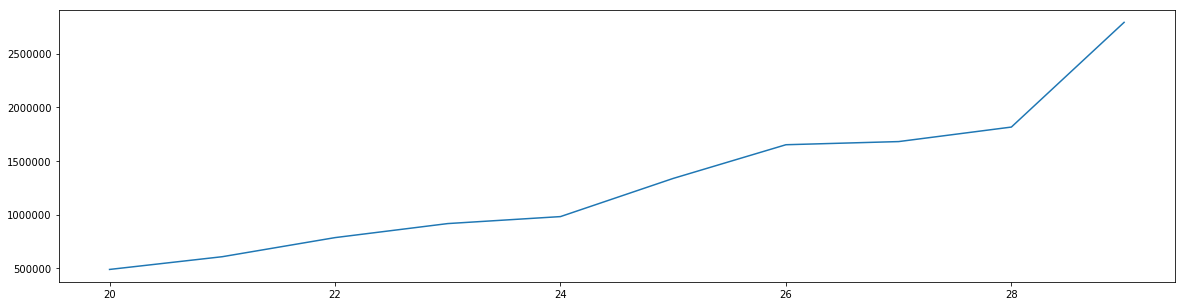

In [97]:
# Here I am ploting perplexsity for test set only
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"], all_topic_models_pandas["P_Test_Cal"])

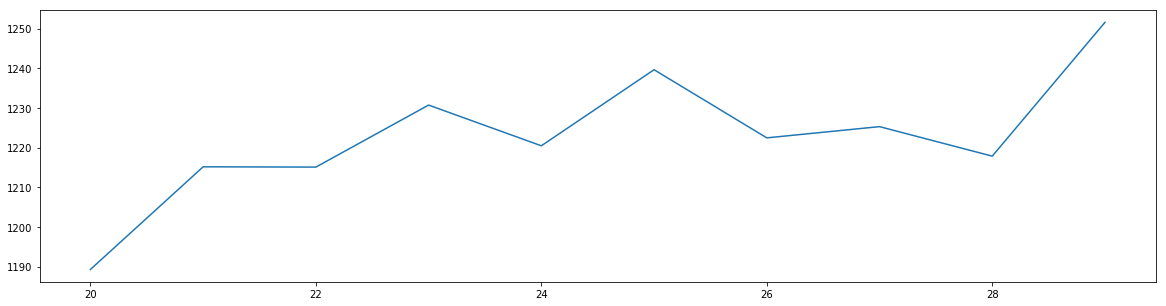

In [98]:
# here I am ploting perplexsity for entire dataset
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"], all_topic_models_pandas["P_All_Cal"])

In [99]:
all_topic_models_pandas["P_All_Diff"] = all_topic_models_pandas["P_All_Cal"] - ([0] + list(all_topic_models_pandas["P_All_Cal"][:-1]))

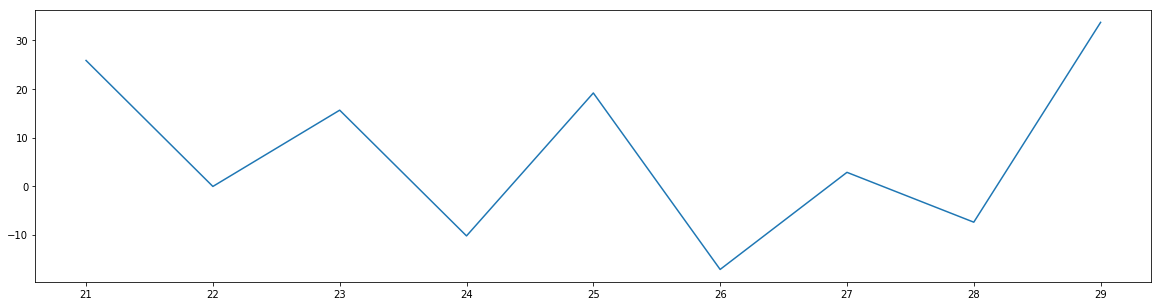

In [100]:
# here I am ploting the difference in perplexsity for whole dataset
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"][1:], all_topic_models_pandas["P_All_Diff"][1:])

In [101]:
all_topic_models_pandas.head(2)

,TopicNumber,P_Test,P_All,CV_Test,CV_All,UMass_Test,UMass_All,P_Test_Cal,P_All_Cal,P_All_Diff
0,20,-13.103277,-7.081134,NaN,0.377998,-9.192253,-2.425891,490547.350681,1189.316341,1189.316341
1,21,-13.319741,-7.102651,NaN,0.394529,-9.080380,-2.683080,609101.997949,1215.183908,25.867567


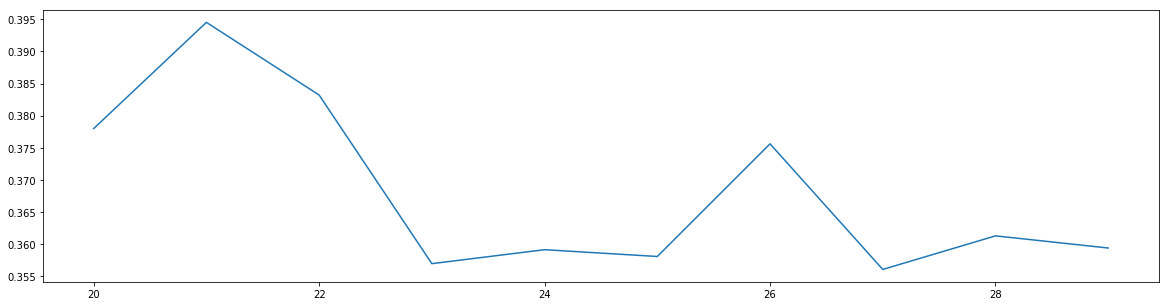

In [102]:
# here I am ploting one of coherence measures
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"], all_topic_models_pandas["CV_All"])

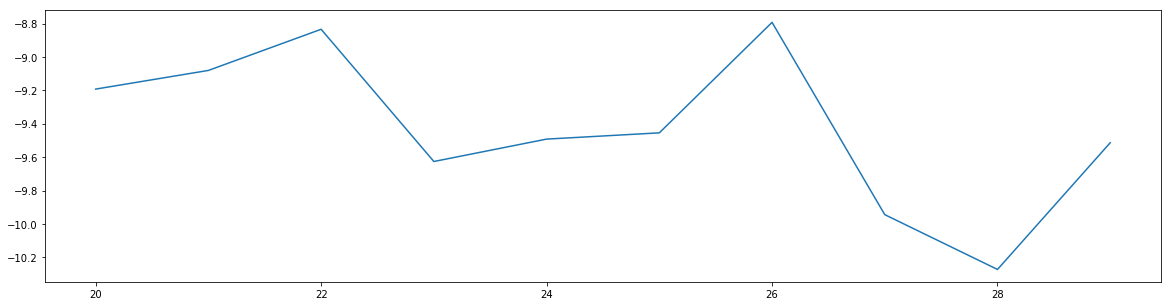

In [104]:
# here I am ploting another coherence measure for test set
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"], all_topic_models_pandas["UMass_Test"])

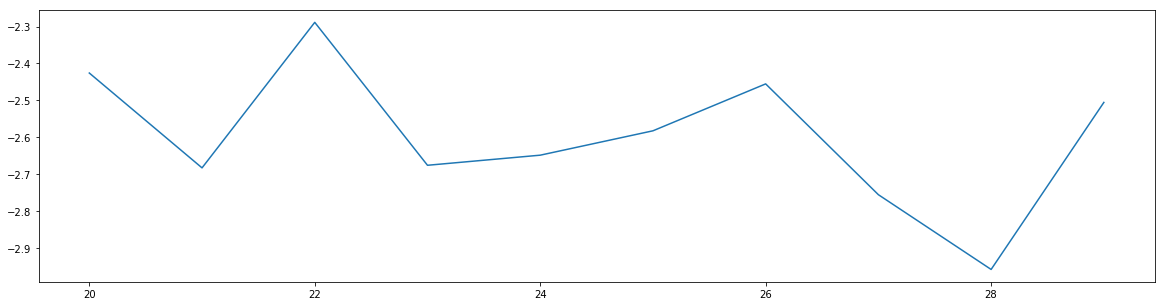

In [106]:
# and here is another coherence measure for entire dataset
plt.figure(figsize=(20,5))
plt.plot(all_topic_models_pandas["TopicNumber"], all_topic_models_pandas["UMass_All"])